In [56]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime
import pandas as pd
import geopandas as gpd
import osmpy
from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
import shapely

cm = str(datetime.today().strftime("%Y%m%d%H%m"))

In [82]:
# EJEMPLO
# polygon = [(4.0, -2.0), (5.0, -2.0), (4.0, -3.0), (3.0, -3.0), (4.0, -2.0)]
# shapely_poly = shapely.geometry.Polygon(polygon)
# 
# line = [(4.0, -2.0000000000000004), (2.0, -1.1102230246251565e-15)]
# shapely_line = shapely.geometry.LineString(line)
# 
# intersection_line = list(shapely_poly.intersection(shapely_line).coords)
# print(intersection_line)
# #shapely_poly.intersection(shapely_line)
# shapely_poly.intersection(shapely_line).is_empty

[(4.0, -2.0000000000000004)]


False

In [202]:
conn = utils.connect_athena(path='../configs/athena.yaml')
qry = f"""
    select line_wkt, count(line_wkt) as count_lines
    from spd_sdv_waze_corona.raw_copy_jams
    group by line_wkt"""
df_lines = pd.read_sql_query(qry, conn)
df_lines.to_csv('/home/soniame/private/line_wkt_count_202010701.csv')
print(df_lines.shape)
df_lines.line_wkt.head()

(1175153, 2)


0    LINESTRING(-75.097855 4.448101, -75.098718 4.4...
1    LINESTRING(-100.921694 22.14878, -100.921864 2...
2    LINESTRING(-84.073469 9.962173, -84.073921 9.9...
3    LINESTRING(-101.001843 22.19166, -101.002284 2...
4    LINESTRING(-75.554978 6.3126, -75.554667 6.313...
Name: line_wkt, dtype: object

In [204]:
df_lines.head()

,line_wkt,count_lines
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",72
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",1
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",237
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",720
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",720


5970.269755


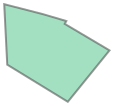

In [173]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
geometry

In [185]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

def intersection_func(line, geometry):
    line_wkt = wkt.loads(line)
    result = geometry.intersection(line_wkt).is_empty == False
    return(int(result))

def threshold_density_func(geometry, threshold_value):
    """Compares the threshold values with the number of lines"""
    
    print('Running')
    
    times = [intersection_func(line, geometry) for line in df_lines.line_wkt]
    intersection = sum(times)
    total = len(times)
    
    print(intersection)
    print(total)
    print(intersection/total)
    
    return (intersection/total) < (threshold_value/total)

In [188]:
len(df_lines.line_wkt)

1175153

In [187]:
result = osmpy.core.katana(geometry, 
                           threshold_func = threshold_density_func, 
                           threshold_value = 110000, 
                           count = 100)

Running
1170476
1175153
0.9960200927028225
Running
367714
1175153
0.31290734057607816
Running
31399
1175153
0.02671907402695649
Running
336321
1175153
0.2861933722672707
Running
45197
1175153
0.03846052386370115
Running
291175
1175153
0.24777624700783643
Running
67368
1175153
0.05732700337743256
Running
223813
1175153
0.1904543493485529
Running
188729
1175153
0.1605995134250604
Running
154887
1175153
0.13180156115841937
Running
122968
1175153
0.10463999155854599
Running
78
1175153
6.637433593753324e-05
Running
122891
1175153
0.1045744681756333
Running
18266
1175153
0.015543507951730541
Running
104689
1175153
0.08908542121749254
Running
31959
1175153
0.027195607720866984
Running
33912
1175153
0.028857518978379838
Running
35160
1175153
0.029919508353380368
Running
802919
1175153
0.6832463517516443
Running
495652
1175153
0.42177656866807983
Running
177026
1175153
0.15064081017535588
Running
7703
1175153
0.006554891150343828
Running
169334
1175153
0.1440952795082853
Running
87319
1175153
0

In [191]:
len(result)

29

INFO|%|s


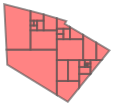

In [190]:
multipolygon = MultiPolygon(result)
multipolygon

In [197]:
grid = list()
for polygon in MultiPolygon(result):  # same for multipolygon.geoms
    grid.append(str(polygon))

In [198]:
cm = str(datetime.today().strftime("%Y%m%d%H%m%s"))
print(cm)

2021073017071627679286


In [199]:
outdf = gpd.GeoDataFrame(columns=['geometry'])
outdf['geometry'] = grid
outdf.to_csv(f"~/private/projects/geo_grid_area_{cm}.csv")

/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [217]:
def intersection_line(line, geometry):
    #print(line)
    line_wkt = wkt.loads(str(line))
    result = geometry.intersection(line_wkt)
    
    return(result)

In [280]:
df_lines['geo_id'] = ""
df_lines.head()

,line_wkt,count_lines,geo_id
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",72,
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",1,
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",237,
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",720,
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",720,


In [ ]:

for polygon in outdf.geometry[:2]:
    print(polygon)
    
    #polygon = outdf.geometry[0]    
    
    geometry = wkt.loads(polygon)
    lines = df_lines[df_lines['geo_id'] == ''].line_wkt
    if len(lines) > 0:
        print(len(lines))
        intersect = [intersection_func(line, geometry) for line in df_lines.line_wkt]
        df_lines.loc[[x > 0 for x in intersect], 'geo_id'] = polygon
    

POLYGON ((-76.6095 -8.368208011344954, -76.6095 -53.97441602268991, -126.421 -23.479, -127.1758303127887 -8.368208011344954, -76.6095 -8.368208011344954))
1175153
POLYGON ((-129.454 37.238, -103.03175 30.45565377007214, -103.03175 -8.368208011344954, -127.1758303127887 -8.368208011344954, -129.454 37.238))
1143754


1175153

,line_wkt,count_lines,geo_id
108,"LINESTRING(-77.067473 -12.054452, -77.066647 -...",4,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
110,"LINESTRING(-76.90705 -12.037244, -76.906877 -1...",85,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
114,"LINESTRING(-77.039555 -12.04849, -77.040325 -1...",6,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
116,"LINESTRING(-76.661292 -11.923681, -76.661081 -...",5,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
382,"LINESTRING(-77.043377 -12.070872, -77.043093 -...",720,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
...,...,...,...
1175063,"LINESTRING(-77.041247 -11.918238, -77.041167 -...",1,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
1175065,"LINESTRING(-77.005402 -11.985124, -77.005618 -...",1,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
1175100,"LINESTRING(-77.070527 -11.949255, -77.070295 -...",1,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."
1175126,"LINESTRING(-77.114541 -12.056617, -77.114588 -...",1,"POLYGON ((-76.6095 -8.368208011344954, -76.609..."


,line_wkt,count_lines,geo_id
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",72,
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",1,
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",237,
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",720,
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",720,
...,...,...,...
1175148,"LINESTRING(-99.247749 19.457225, -99.248203 19...",1,
1175149,"LINESTRING(-76.176653 -13.571443, -76.176437 -...",1,
1175150,"LINESTRING(-63.154796 -17.7774, -63.154864 -17...",1,
1175151,"LINESTRING(-46.750772 -23.26417, -46.750684 -2...",1,
